In [1]:
import numpy as np
import pandas as pd
from music21 import *

# Default setting

Default tempo of midi is 500,000 $\mu$ s/beat

In [2]:
tempo = 500000 # (micro sec)/beat
ticks_per_beat = 9600 # ticks/beat
ticks_per_sec = ticks_per_beat / (tempo/10**6)
sec_per_tick = 1/ticks_per_sec
print("ticks/s:", ticks_per_sec)
print("s/tick:", sec_per_tick)

ticks/s: 19200.0
s/tick: 5.208333333333334e-05


# Load score (xml) data

In [3]:
path="data/pedb2_v0.0.1.b/"
targetxml="bac-wtc101-p-a-p1/bac-wtc101-p.xml"
#targetmid="bac-wtc101-p-a-p1/bac-wtc101-p-a-p1.mid"

#piecemid=converter.parse(path+targetmid)
piecexml=converter.parse(path+targetxml)
piece=piecexml

for i, p in enumerate(range(len(piecexml))):
    print(i, piece[p])
print("# of measures:",len(piece[4]))

0 <music21.text.TextBox 'Johann Seb...'>
1 <music21.text.TextBox 'ISBN4-276-...'>
2 <music21.text.TextBox 'Das Wohlte...'>
3 <music21.metadata.Metadata object at 0x12a74e110>
4 <music21.stream.PartStaff P1-Staff1>
5 <music21.stream.PartStaff P1-Staff2>
6 <music21.layout.ScoreLayout>
7 <music21.layout.StaffGroup <music21.stream.PartStaff P1-Staff1><music21.stream.PartStaff P1-Staff2>>
# of measures: 36


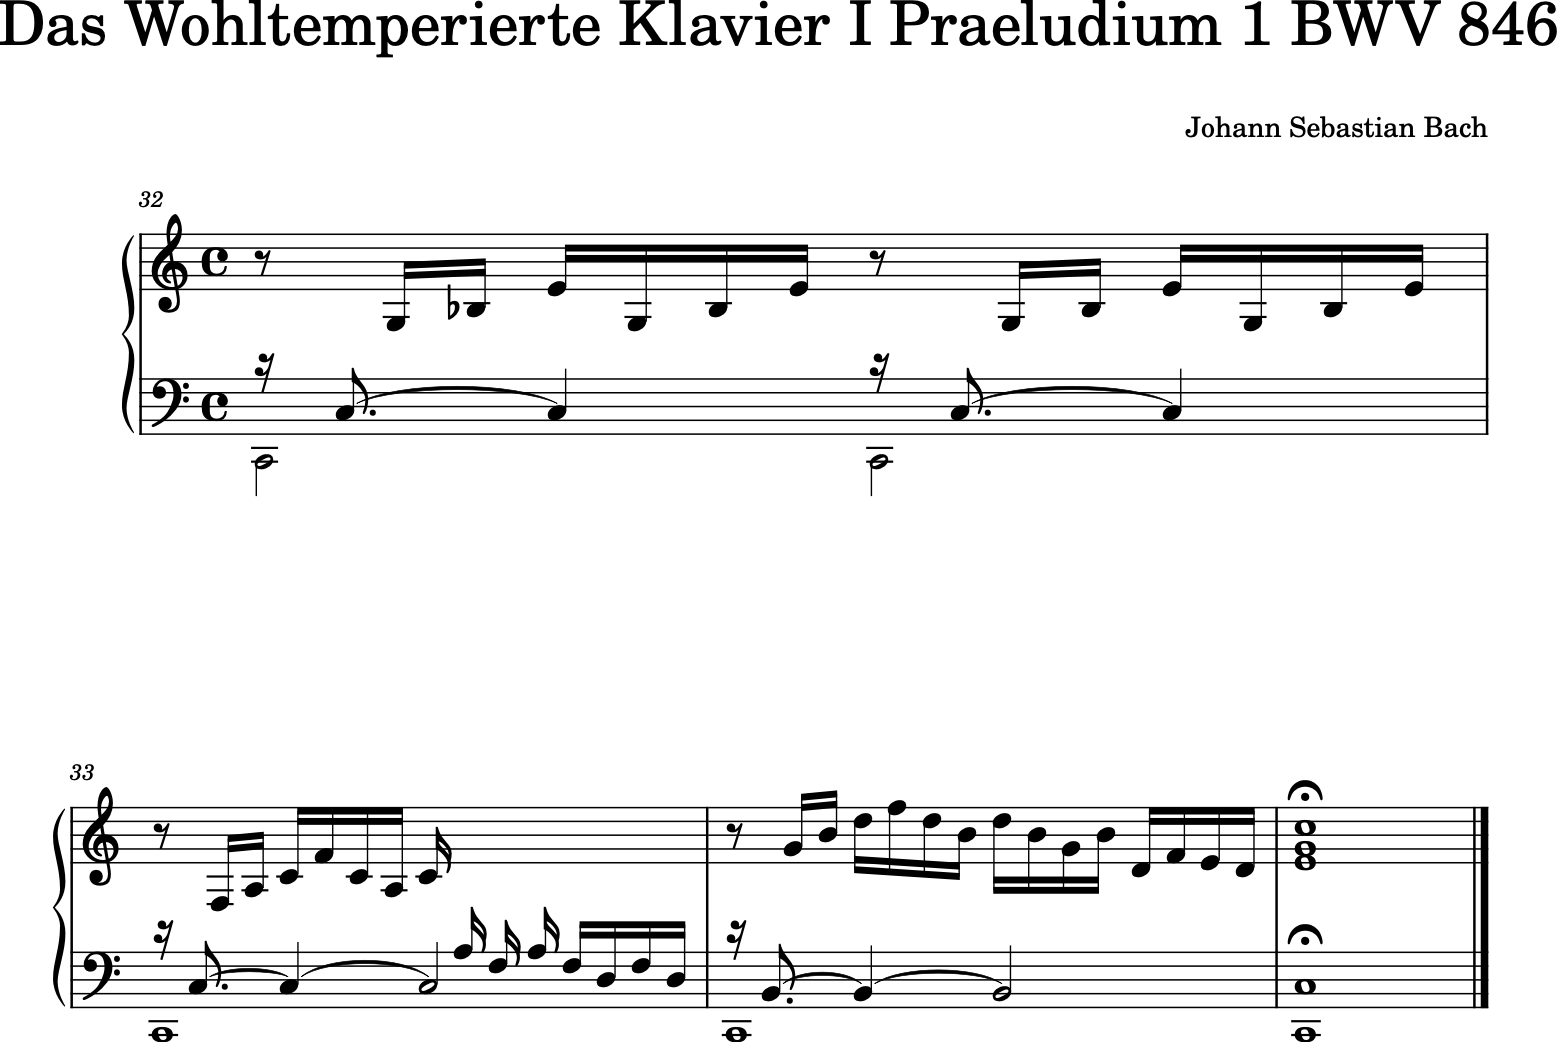

In [10]:
musescorePath = '/Applications/MuseScore 4.app/Contents/MacOS/mscore'
us = environment.UserSettings()
us['musicxmlPath'] = musescorePath
us['musescoreDirectPNGPath'] = musescorePath

piece.measures(32,35).show()

# Load performance data (csv) and extract note_on

最後の5音は和音。その直前にトリルあり。最後の10音は削除

In [ ]:
path="outputs/"
#target="bac-inv001-o-p1.csv"
target="bac-wtc101-p-a-p1.csv"
df=pd.read_csv(path+target)

# note_onでvelocityが0になっているものはnote_offにする。
print(df[(df["type"] == "note_on") & (df["velocity"] == 0)]['type'])
df.loc[ (df["type"] == "note_on") & (df["velocity"] == 0), 'type'] = 'note_off'

# extract note_on
note_on=df[df['type']=='note_on'][['time_counter','note','note_name','velocity']]
note_on['time_counter']=note_on['time_counter']/ticks_per_sec

print("final note start [tick]: ", note_on[-1:])
print("Time Length [s]:", note_on[-1:]['time_counter']/ticks_per_sec)

#最後の5音は和音。その直前にトリルあり。最後の9音は削除必要
#また，最後の2小節はritなので，削除
#最後の小節の音数:5
#最後から2番目の小節の音数:18
#最後から3番目の小節までは音数:16

note_on=note_on[:-55]
#note_on=note_on[:-10]


#note_on=note_on.reindex(index=range(len(note_on)))
display(note_on[:5])

## ビート情報追加
何拍目に当たるかという情報を追加

- beat2 : 8/8拍子
- beat4 : 4/4拍子
- beat8 : 2/2拍子

### パルス

- pulse2: 2音ごとにパルス番号(0,1,0,1,)
- pulse4: 4音ごとにパルス番号(0,1,2,3)
- pulse8: 8音ごとにパルス番号(0,1,...,7)
- pulse16: 16音ごとにビート番号(0,1,...,15)
- pulse32: 32音ごとにビート番号(0,1,...,31)

In [ ]:
note_on.index=range(len(note_on))

N=5
for i in range(0,N):
    k=2**i
    #note_on["beat"+str(k)]=((note_on.index // k) % (16//k))
    note_on["beat_n"+str(k)]=((note_on.index // k))
    note_on["pulse"+str(k)]=note_on.index % k
    
display(note_on[:5])
display(note_on[15:20])

In [ ]:
interval1=pd.DataFrame(note_on.time_counter.diff(1).shift(-1))
interval1=interval1.rename(columns={"time_counter":"interval"})
interval1=pd.concat([note_on,interval1], axis=1)
interval1.index=range(len(interval1))
display(interval1)

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import pyplot as plt
import seaborn as sns

df=interval1
# get deviation from the mean

df["Dinterval"]=df["interval"]-df["interval"].mean()
df["Dvelocity"]=df["velocity"]-df["velocity"].mean()

# prepare colormap
colors = sns.color_palette('Set2', n_colors=4)

# graphics

sns.set_style(style="whitegrid")
fig, ax=plt.subplots(nrows=2, ncols=1, figsize=(24,12))

# set target
target=df[360:]

g1=sns.barplot(data=target, x="time_counter",y="Dinterval", palette=colors, ax=ax[0])
g2=sns.barplot(data=target, x="time_counter",y="Dvelocity", palette=colors, ax=ax[1])
grp=[g1,g2]

notes=list(target.note_name)
for g in grp:
    g.set_xlabel("time")
    g.set_xticks(range(len(notes)))
    g.set_xticklabels(notes)
    ymin,ymax=g.get_ylim()
    g.vlines(x=np.arange(0,len(target),4)-0.5,lw=0.5,ymin=ymin, ymax=ymax)

g1.set_ylabel("interval")
g2.set_ylabel("velocity")

## 音長, 拍長の平均

In [ ]:
def get_stats(df, verbose=False):
    mean, std = df.mean(), df.std()
    if verbose:
        print("  mean=", mean)
        print("  std=", std)
        print("  std/mean=", std / mean)
    return mean, std, std / mean

def plot_intervals(df,beatname):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(22, 4))
    x=0; axi=ax[x]
    sns.barplot(data=df, x=beatname, y="interval", ax=axi)

    x+=1; axi=ax[x]
    sns.boxplot(data=df, x=beatname, y="interval", ax=axi)

    x+=1; axi=ax[x]
    sns.stripplot(data=df, x=beatname, y="interval", ax=axi)

    x+=1; axi=ax[x]
    sns.violinplot(data=df, x=beatname, y="interval", ax=axi)

    df_stat=df[['interval',beatname]].groupby(beatname).agg(['mean','std'])['interval']
    df_stat["cov"]=df_stat['std']/df_stat['mean']
    #display(df_stat)

    x+=1; axi=ax[x]
    sns.barplot(data=df_stat, x=df_stat.index, y="cov", ax=axi)
    axi.set_xlabel(beatname)
    axi.set_ylabel("coefficient of variation")    

    plt.show()

### 16分音符4個の音長分布

In [ ]:
print("4-note pattern")
plot_intervals(df=interval1,beatname="pulse4")

- 16分音符16個の平均音長
- 8分音符の長さ8個の平均音長
- 4分音符の長さ4個の平均音長
- 2分音符の長さ2個の平均音長

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

df=interval1

N=4
for i in range(0,N):
    #display(df[:5])
    
    k=2**i
    print("[{}-note grouping]".format(k))

    beatname="beat"+str(k)
    beat_n_name="beat_n"+str(k)
    df_tmp=df[['interval',beat_n_name]].groupby(beat_n_name).sum()
    df_tmp[beatname]=df_tmp.index % (16//k)
    
    plot_intervals(df=df_tmp, beatname=beatname)

## inter-beat analysis
get interval between notes of the same pulse

各拍の長さではなく，beat4なら1拍目から1拍目,2拍目から2拍目の長さを比べる

In [ ]:
N=5
intervals=[]
for i in range(N):
    k=2**i
    tmp_duration=pd.DataFrame(note_on.time_counter.diff(k).shift(-k))
    tmp_duration=tmp_duration.rename(columns={"time_counter":"interval"})
    tmp_duration=pd.concat([note_on,tmp_duration], axis=1)
    tmp_duration.index=range(len(tmp_duration))
    #display(tmp_duration)
    intervals.append(tmp_duration)

for i ,j in enumerate(range(len(intervals))):
    print("intervals[{}]: interval between {}-step notes".format(i,2**i))
    display(intervals[i][:3])

In [ ]:
def plot_intervals(df,beatname):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(22, 4))
    x=0; axi=ax[x]
    sns.barplot(data=df, x=beatname, y="interval", ax=axi)

    x+=1; axi=ax[x]
    sns.boxplot(data=df, x=beatname, y="interval", ax=axi)

    x+=1; axi=ax[x]
    sns.stripplot(data=df, x=beatname, y="interval", ax=axi)

    x+=1; axi=ax[x]
    sns.violinplot(data=df, x=beatname, y="interval", ax=axi)

    df_stat=df[['interval',beatname]].groupby(beatname).agg(['mean','std'])['interval']
    df_stat["cov"]=df_stat['std']/df_stat['mean']
    #display(df_stat)

    x+=1; axi=ax[x]
    sns.barplot(data=df_stat, x=df_stat.index, y="cov", ax=axi)
    axi.set_xlabel(beatname)
    axi.set_ylabel("coefficient of variation")    


In [ ]:
print("[between neighboring notes]")
get_stats(intervals[0]["interval"], verbose=True)

print("[between pulses]")

N=5
for i in range(1,N):
    k=2**i
    
    pulsename="pulse"+str(k)
    df=intervals[i]
    
    get_stats(df["interval"])
    
    print("[{}-note grouping]".format(k))
    means = np.empty(k)
    stds = np.empty(k)
    cov = np.empty(k)  # coefficient of variation (std/mean)

    plot_intervals(df=df, beatname=pulsename)

    plt.show()

## interval vs velocity
### interval[t,t+1] vs velocity[t]

In [ ]:
sns.scatterplot(data=target, x="Dduration", y="Dvelocity", palette=colors)

### interval[t,t+1] vs velocity[t+1]

In [ ]:
target2=target
target2["Dvelocity"]=target["Dvelocity"].shift(-1)
sns.scatterplot(data=target2, x="Dduration", y="Dvelocity", palette=colors)

## interval between each pulse

In [ ]:
help(range)